# DATOS HISTORICOS DE BITCOIN
**DATASET**  https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data  

## **Contexto del dataset** 
*Este dataset contiene información de la criptomoneda bitcoin, la información es desde el 01/01/2012 hasta mas o menos el 09/09/2025 (Aqui lo descargué, este dataset se actualiza a diario al parecer), entre las variables que podemos encontrar es la fecha en formato UNIX "Timestamp", valor de apertura "Open", el valor más alto "High", el valor mas bajo "Low", el valor de cierre "Close", Volumen transaccionado "Volume". Este dataset se maneja en ventanas de 1 minuto por lo que tiene la información completa, la idea es inicialmente transformarlo a dia para reducir la cantidad de valores a trabajar.*
## **Variables**
***Timestamp** - UNIX / segundos*  
***Open** - apertura*  
***High** - valor más alto*  
***Low** - valor más bajo*  
***Close** - valor de cierre*  
***Volume** - cantidad transaccionada*  


# **IMPORTACIONES** 

In [55]:
#Ejecutar las importaciones más generales
import pandas as pd
import seaborn as sns
import os, sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Este bloque sirve para transformar los datos a dias y reducir el peso del dataset.

In [56]:

# 🔙 Subir una carpeta desde la ubicación actual del notebook
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ruta del archivo original (minutos)
path = os.path.join(parent_dir, "data", "01_raw", "btcusd_1-min_data.csv")

print("📄 Archivo detectado en:", path)

# Verificar existencia
if not os.path.exists(path):
    raise FileNotFoundError(f"❌ No se encontró el archivo en: {path}")

# Detectar tamaño del archivo
file_size_mb = os.path.getsize(path) / (1024**2)
print(f"📦 Tamaño del archivo: {file_size_mb:.2f} MB")

# Crear acumulador de resultados
df_daily_total = []

# Leer todo el archivo por chunks (procesa el dataset completo)
chunk_size = 500_000  # medio millón de filas por bloque (~200 MB aprox)
print("🚀 Procesando dataset completo en bloques...")

for i, chunk in enumerate(pd.read_csv(path, chunksize=chunk_size)):
    print(f"🧩 Procesando bloque {i+1}...")

    # Asegurar conversión de tiempo
    chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'], unit='s')
    chunk = chunk.set_index('Timestamp')

    # Resample diario (1D)
    df_daily = chunk.resample('1D').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    })
    df_daily_total.append(df_daily)

# Unir todos los bloques diarios
print("🧮 Combinando resultados...")
df_daily_full = pd.concat(df_daily_total).sort_index()

# Agrupar otra vez para consolidar (por si hay solapamiento entre chunks)
df_daily_full = df_daily_full.groupby(df_daily_full.index).agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}).dropna(subset=['Open'])

# 🆕 Agregar columna 't' = número de día consecutivo
df_daily_full['t'] = range(1, len(df_daily_full) + 1)

print("✅ Transformación completa.")
print("Dimensiones finales:", df_daily_full.shape)
display(df_daily_full.head())

# Guardar versión diaria en formato Parquet (más rápido y comprimido)
output_path = os.path.join(parent_dir, "data", "02_intermediate", "btcusd_daily.parquet")
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df_daily_full.to_parquet(output_path, index=True, compression="snappy")
print(f"💾 Dataset diario guardado en formato Parquet en: {output_path}")

📄 Archivo detectado en: c:\Users\AlexandreKz\Documents\GitHub\SUMATIVA2_IDN\data\01_raw\btcusd_1-min_data.csv
📦 Tamaño del archivo: 358.74 MB
🚀 Procesando dataset completo en bloques...
🧩 Procesando bloque 1...
🧩 Procesando bloque 2...
🧩 Procesando bloque 3...
🧩 Procesando bloque 4...
🧩 Procesando bloque 5...
🧩 Procesando bloque 6...
🧩 Procesando bloque 7...
🧩 Procesando bloque 8...
🧩 Procesando bloque 9...
🧩 Procesando bloque 10...
🧩 Procesando bloque 11...
🧩 Procesando bloque 12...
🧩 Procesando bloque 13...
🧩 Procesando bloque 14...
🧩 Procesando bloque 15...
🧮 Combinando resultados...
✅ Transformación completa.
Dimensiones finales: (4994, 6)


,Open,High,Low,Close,Volume,t
Timestamp,,,,,,
2012-01-01,4.5800,4.8400,4.5800,4.8400,10.0000,1
2012-01-02,4.8400,5.0000,4.8400,5.0000,10.1000,2
2012-01-03,5.0000,5.3200,5.0000,5.2900,107.0853,3
2012-01-04,5.2900,5.5700,4.9300,5.5700,107.2333,4
2012-01-05,5.5700,6.4600,5.5700,6.4200,70.3287,5


💾 Dataset diario guardado en formato Parquet en: c:\Users\AlexandreKz\Documents\GitHub\SUMATIVA2_IDN\data\02_intermediate\btcusd_daily.parquet


# CARGA DEL DATASET NUEVO

In [57]:
# 🔙 Subir una carpeta desde la ubicación actual del notebook
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Ruta del dataset diario (Parquet)
daily_path = os.path.join(parent_dir, "data", "02_intermediate", "btcusd_daily.parquet")

print("📄 Archivo detectado en:", daily_path)

# Verificar existencia
if not os.path.exists(daily_path):
    raise FileNotFoundError(f"❌ No se encontró el archivo en: {daily_path}")

# Cargar dataset diario
btc_daily = pd.read_parquet(daily_path)

# Confirmar carga
print(f"✅ Dataset diario cargado correctamente desde:\n{daily_path}")
print(f"Dimensiones: {btc_daily.shape}")
display(btc_daily.head())

📄 Archivo detectado en: c:\Users\AlexandreKz\Documents\GitHub\SUMATIVA2_IDN\data\02_intermediate\btcusd_daily.parquet
✅ Dataset diario cargado correctamente desde:
c:\Users\AlexandreKz\Documents\GitHub\SUMATIVA2_IDN\data\02_intermediate\btcusd_daily.parquet
Dimensiones: (4994, 6)


,Open,High,Low,Close,Volume,t
Timestamp,,,,,,
2012-01-01,4.5800,4.8400,4.5800,4.8400,10.0000,1
2012-01-02,4.8400,5.0000,4.8400,5.0000,10.1000,2
2012-01-03,5.0000,5.3200,5.0000,5.2900,107.0853,3
2012-01-04,5.2900,5.5700,4.9300,5.5700,107.2333,4
2012-01-05,5.5700,6.4600,5.5700,6.4200,70.3287,5


# Observar primeras y ultimas columnas

In [58]:
btc_daily.head()

,Open,High,Low,Close,Volume,t
Timestamp,,,,,,
2012-01-01,4.5800,4.8400,4.5800,4.8400,10.0000,1
2012-01-02,4.8400,5.0000,4.8400,5.0000,10.1000,2
2012-01-03,5.0000,5.3200,5.0000,5.2900,107.0853,3
2012-01-04,5.2900,5.5700,4.9300,5.5700,107.2333,4
2012-01-05,5.5700,6.4600,5.5700,6.4200,70.3287,5


In [59]:
btc_daily.tail()

,Open,High,Low,Close,Volume,t
Timestamp,,,,,,
2025-08-29,"112,581.0000","112,654.0000","107,488.0000","108,362.0000","1,977.3241",4990
2025-08-30,"108,376.0000","108,924.0000","107,389.0000","108,827.0000",790.8301,4991
2025-08-31,"108,827.0000","109,503.0000","108,092.0000","108,269.0000",747.3678,4992
2025-09-01,"108,268.0000","109,907.0000","107,270.0000","109,244.0000","1,584.0618",4993
2025-09-02,"109,255.0000","111,775.0000","108,426.0000","111,198.0000","2,117.6141",4994


# Estadística descriptiva

In [60]:
# Mostrar estadísticas descriptivas (excluyendo la variable 't')
pd.options.display.float_format = '{:,.4f}'.format  # formato bonito
# Seleccionar solo las columnas numéricas excepto 't'
cols = [c for c in btc_daily.select_dtypes(include='number').columns if c != 't']
# Calcular estadísticas básicas
desc = btc_daily[cols].describe().T  # transponer → variables como filas
# Calcular asimetría y curtosis
extra = btc_daily[cols].agg(['skew', 'kurtosis']).T
# Combinar ambas tablas
desc_full = pd.concat([desc, extra], axis=1)
# Mostrar resultado final en una sola tabla
print("📊 Estadísticas descriptivas de las variables del dataset diario (sin incluir 't'):\n")
display(desc_full)

📊 Estadísticas descriptivas de las variables del dataset diario (sin incluir 't'):



,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Open,"4,994.0000","19,699.8269","27,801.0802",4.3800,434.3475,"6,998.2250","29,349.3475","123,360.0000",1.7037,2.2253
High,"4,994.0000","20,140.6465","28,323.9414",4.3800,444.1425,"7,234.0600","29,960.0000","124,517.0000",1.6869,2.1460
Low,"4,994.0000","19,241.5728","27,254.8095",3.8000,425.5575,"6,775.3400","28,998.8250","118,972.0000",1.7225,2.3154
Close,"4,994.0000","19,722.0000","27,829.7277",4.3800,434.6250,"7,003.4400","29,363.5400","123,360.0000",1.7032,2.2217
Volume,"4,994.0000","7,474.6302","9,048.8317",0.0000,"1,998.7190","4,571.8682","9,651.6111","127,286.4865",3.9511,28.3157


**Rangos de valores indican la volatilidad historica del valor del bitcoin, el rango mínimo va por ~$4 hasta ~$124.000**  
**Coef de asimetria (Skew) indica una distribución sesgada hacía la derecha con un sesgo positivo**  
**Kurtosis de 2.1 - 2.3 distribución apuntada, esto indica presencia de eventos extremos**  
**En este caso podemos observar que la variable std es mucho más alta que la media, lo que representa una alta dispersión de valores a lo largo del tiempo**


## Evolución del valor a lo largo del tiempo (Usando variable T y Close)

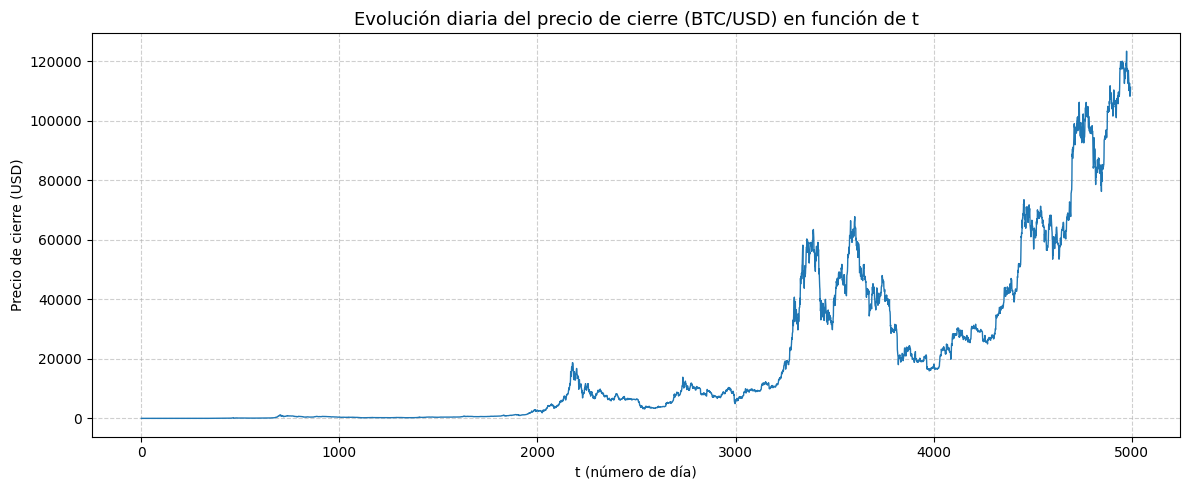

In [61]:
plt.figure(figsize=(12, 5))
plt.plot(btc_daily["t"], btc_daily["Close"], linewidth=1, color="tab:blue")
plt.title("Evolución diaria del precio de cierre (BTC/USD) en función de t", fontsize=13)
plt.xlabel("t (número de día)")
plt.ylabel("Precio de cierre (USD)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# Ver outliers 

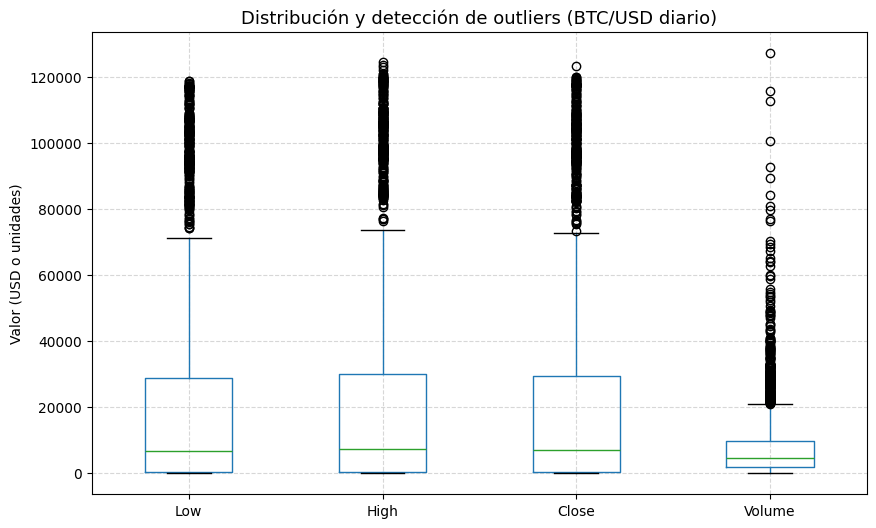

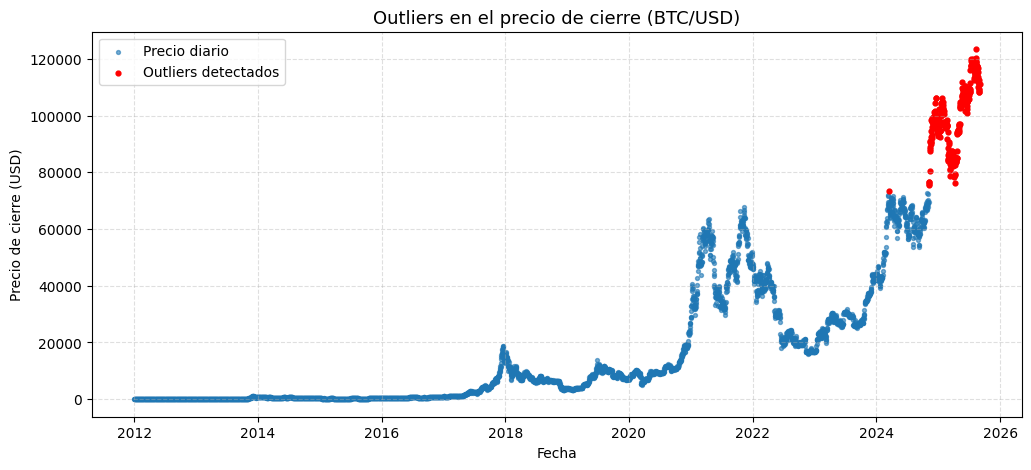

In [62]:
# ==========================
# 1️⃣ BOX PLOT COMPARATIVO
# ==========================
plt.figure(figsize=(10,6))
btc_daily[['Low','High','Close','Volume']].boxplot()
plt.title("Distribución y detección de outliers (BTC/USD diario)", fontsize=13)
plt.ylabel("Valor (USD o unidades)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# ==========================
# 2️⃣ SCATTER TEMPORAL DE OUTLIERS
# ==========================
# Calcular límites IQR para la variable Close
Q1, Q3 = btc_daily["Close"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# Detectar outliers
outliers = btc_daily[(btc_daily["Close"] < lower) | (btc_daily["Close"] > upper)]

# Graficar
plt.figure(figsize=(12,5))
plt.scatter(btc_daily.index, btc_daily["Close"], s=8, alpha=0.6, label="Precio diario", color="tab:blue")
plt.scatter(outliers.index, outliers["Close"], color="red", s=12, label="Outliers detectados")
plt.title("Outliers en el precio de cierre (BTC/USD)", fontsize=13)
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (USD)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

**Podemos ver que existen muchos valores atipicos, en todas las variables se pueden observar outliers, es necesario escalarlas para reducir su impacto**

# Escalado de variables con ScikitLearn

In [63]:
# Seleccionar columnas a escalar
cols = ['Low', 'High', 'Close', 'Volume']

# Inicializar escalador
scaler = StandardScaler()

# Ajustar y transformar
scaled_data = scaler.fit_transform(btc_daily[cols])

# Crear nuevo DataFrame escalado
btc_scaled = pd.DataFrame(scaled_data, columns=cols, index=btc_daily.index)

# Verificar resultados
print("📊 Primeras filas del dataset escalado:\n")
display(btc_scaled.head())

print("\n📈 Estadísticas tras el escalado (deben tener media ≈ 0 y std ≈ 1):\n")
display(btc_scaled.describe().T[['mean', 'std']])

📊 Primeras filas del dataset escalado:



,Low,High,Close,Volume
Timestamp,,,,
2012-01-01,-0.7059,-0.7110,-0.7086,-0.8250
2012-01-02,-0.7059,-0.7110,-0.7086,-0.8250
2012-01-03,-0.7059,-0.7110,-0.7085,-0.8143
2012-01-04,-0.7059,-0.7110,-0.7085,-0.8143
2012-01-05,-0.7059,-0.7109,-0.7085,-0.8183



📈 Estadísticas tras el escalado (deben tener media ≈ 0 y std ≈ 1):



,mean,std
Low,-0.0000,1.0001
High,0.0000,1.0001
Close,0.0000,1.0001
Volume,-0.0000,1.0001


**EXPORTAR DATASET ESCALADO**

In [64]:
# Definir ruta de salida
output_path = os.path.join(parent_dir, "data", "03_primary", "btcusd_scaled.parquet")

# Crear carpeta si no existe
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Guardar en formato Parquet (rápido y comprimido)
btc_scaled.to_parquet(output_path, index=True, compression="snappy")

print(f"✅ Dataset escalado guardado correctamente en:\n{output_path}")

✅ Dataset escalado guardado correctamente en:
c:\Users\AlexandreKz\Documents\GitHub\SUMATIVA2_IDN\data\03_primary\btcusd_scaled.parquet


# **Una pequeña explicación ( lo que entendí )** 
### *Este escalado deja la media en 0 y realiza un escalado relativo en std que va de valores entre -1 al 1, de esta forma los valores quedan en una misma magnitud, esto permite al modelo comparar bien la importancia de variables y no otorgarle mayor peso a lo que son outliers*

## **CARGADO Y REVISIÓN DEL DATASET ESCALADO CON SCIKITLEARN**

In [65]:
# Ruta del archivo escalado
scaled_path = os.path.join(parent_dir, "data", "03_primary", "btcusd_scaled.parquet")

# Verificar existencia
if not os.path.exists(scaled_path):
    raise FileNotFoundError(f"❌ No se encontró el archivo en: {scaled_path}")

# Cargar el dataset
btc_scaled_loaded = pd.read_parquet(scaled_path)

# Confirmar carga
print(f"✅ Dataset escalado cargado correctamente desde:\n{scaled_path}")
print(f"Dimensiones: {btc_scaled_loaded.shape}")
display(btc_scaled_loaded.head())

✅ Dataset escalado cargado correctamente desde:
c:\Users\AlexandreKz\Documents\GitHub\SUMATIVA2_IDN\data\03_primary\btcusd_scaled.parquet
Dimensiones: (4994, 4)


,Low,High,Close,Volume
Timestamp,,,,
2012-01-01,-0.7059,-0.7110,-0.7086,-0.8250
2012-01-02,-0.7059,-0.7110,-0.7086,-0.8250
2012-01-03,-0.7059,-0.7110,-0.7085,-0.8143
2012-01-04,-0.7059,-0.7110,-0.7085,-0.8143
2012-01-05,-0.7059,-0.7109,-0.7085,-0.8183


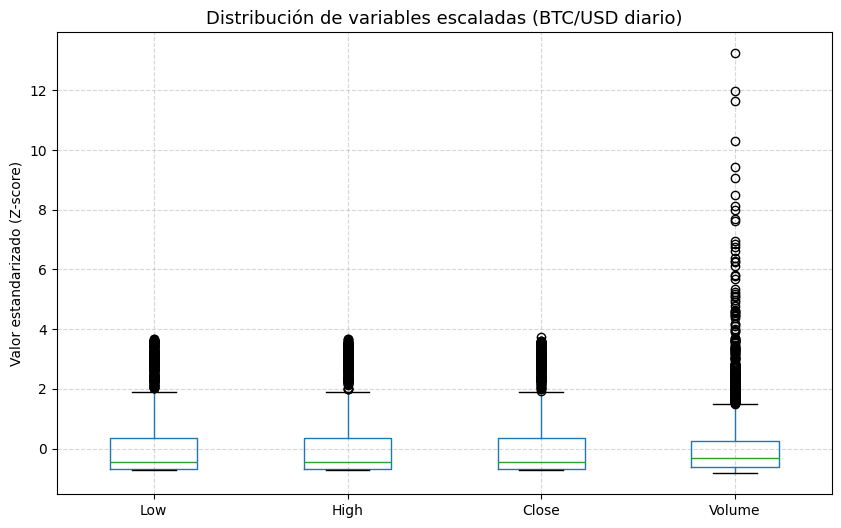

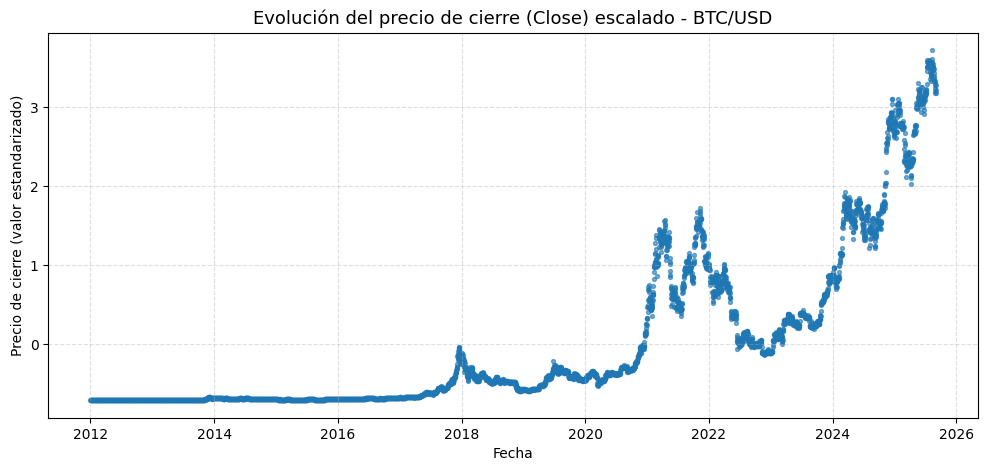

In [66]:
plt.figure(figsize=(10,6))
btc_scaled[['Low','High','Close','Volume']].boxplot()
plt.title("Distribución de variables escaladas (BTC/USD diario)", fontsize=13)
plt.ylabel("Valor estandarizado (Z-score)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

plt.figure(figsize=(12,5))
plt.scatter(btc_scaled.index, btc_scaled["Close"], s=8, alpha=0.6, color="tab:blue")
plt.title("Evolución del precio de cierre (Close) escalado - BTC/USD", fontsize=13)
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (valor estandarizado)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

### Básicamente se puede ser que el escalado mantiene los datos, los deja a una escala más razonables lo que evita que los modelos se vean afectados. Con el segundo grafico podemos ver que se mantiene la figura del crecimiento después del escalado que se realizó. Aún así podemos ver que la variable volume quedó con algunos valores muy altos, aunque no es tan relevante porque no se utilizará mucho al momento de la regresión.

# Matriz de correlación

📈 Matriz de correlación:



,Low,High,Close,Volume
Low,1.0000,0.9994,0.9997,-0.3275
High,0.9994,1.0000,0.9997,-0.3221
Close,0.9997,0.9997,1.0000,-0.3245
Volume,-0.3275,-0.3221,-0.3245,1.0000


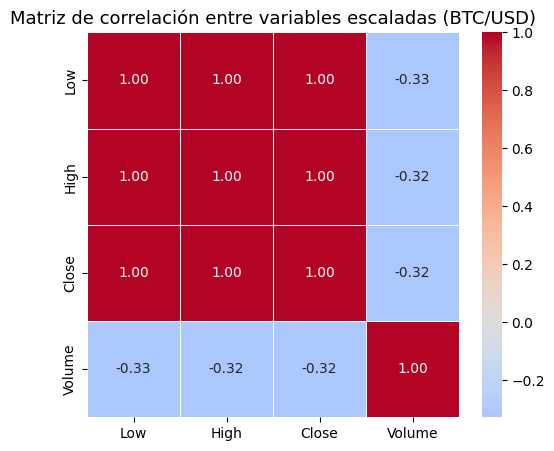

In [67]:
# Calcular matriz de correlación
corr_matrix = btc_scaled.corr()

# Mostrar valores numéricos
print("📈 Matriz de correlación:\n")
display(corr_matrix.round(4))

# Visualización tipo heatmap
plt.figure(figsize=(6,5))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Matriz de correlación entre variables escaladas (BTC/USD)", fontsize=13)
plt.show()

### Conclusión  

*Según lo observado en el mapa de calor podemos ver que la correlación entre las variables es casi perfecta, lo que afecta al análisis y no permite a un solo modelo comprender cual tiene más peso sobre la variables "Close"*   
  

*Recordemos la hipotesis: **Las caídas en el precio mínimo (Low) tienen un efecto más fuerte sobre el precio de cierre que los incrementos en el precio máximo (High), lo que sugiere un sesgo bajista en la dinámica de mercado de Bitcoin.***

*Para hacer una correcta evaluación del caso según la hipotesis realizaré dos modelos: **Modelo A** que involucra **Close ~ Low** y **Modelo B** que involucra **Close ~ High**, de esta forma podemos medir el impacto por medio de variables como R² y evitar la multicolinealidad*

# Antes de proceder con el siguiente notebook, ver nulos

**Esto me quedo un poco fuera de lugar pero me gustaría añadirlo solo para comprobar que no existen valores nulos**

In [68]:
# Contar valores nulos por columna
nulos = btc_scaled.isnull().sum()

# Calcular el porcentaje de nulos por variable
nulos_pct = (nulos / len(btc_scaled)) * 100

# Combinar resultados en una tabla ordenada
tabla_nulos = pd.DataFrame({
    'Nulos': nulos,
    'Porcentaje (%)': nulos_pct.round(4)
}).sort_values(by='Nulos', ascending=False)

print("📋 Revisión de valores nulos en el dataset escalado:\n")
display(tabla_nulos)

📋 Revisión de valores nulos en el dataset escalado:



,Nulos,Porcentaje (%)
Low,0,0.0000
High,0,0.0000
Close,0,0.0000
Volume,0,0.0000


**Resultados indican que no hay nulos en ninguna columna**

# **PROCEDER CON EL SIGUIENTE NOTEBOOK *"02_modeladoYResultados"***